## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp033'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

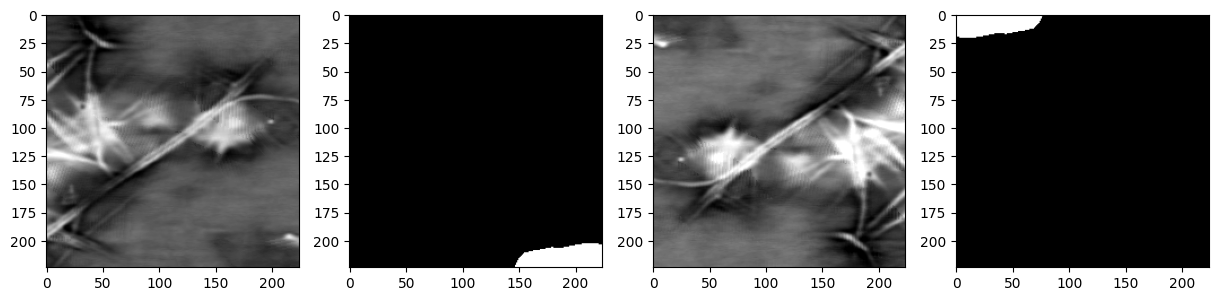

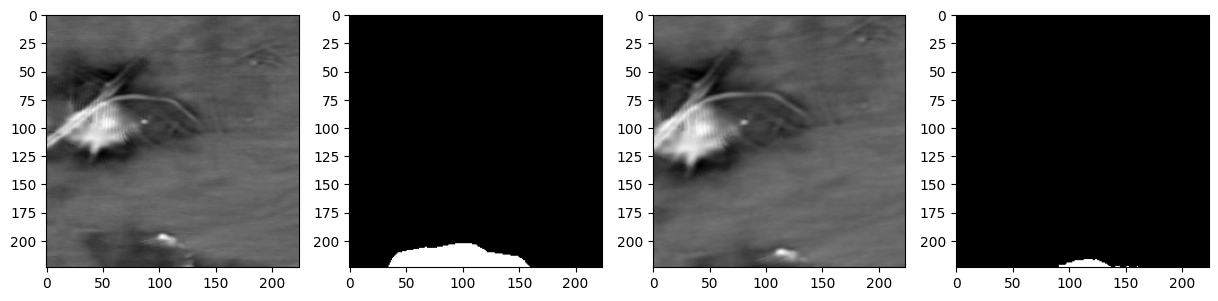

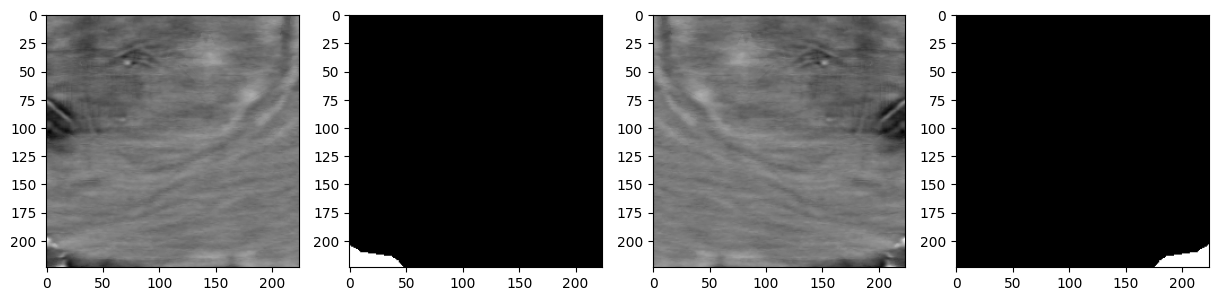

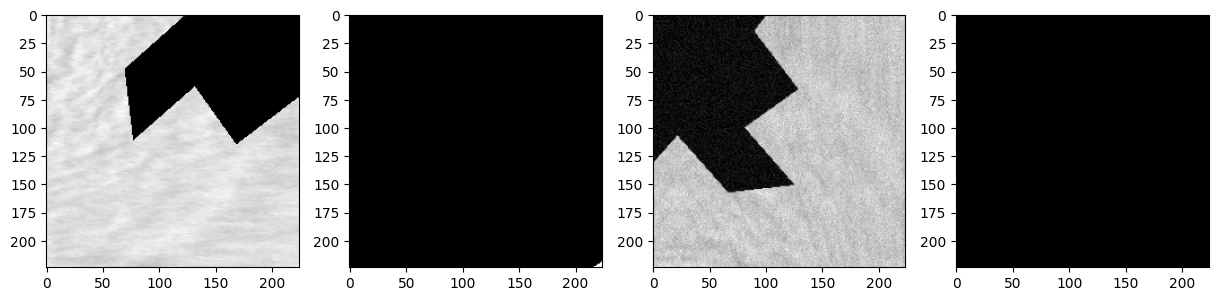

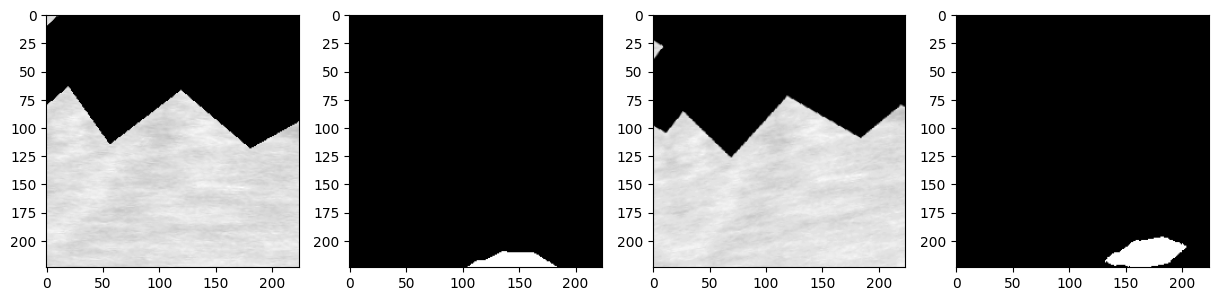

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53930

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096689917456337
th: 0.15, fbeta: 0.12100277939378781
th: 0.2, fbeta: 0.18541398395070202
th: 0.25, fbeta: 0.22685183195076458
th: 0.3, fbeta: 0.2763999148297604
th: 0.35, fbeta: 0.3280361184521963
th: 0.4, fbeta: 0.37132818301008375
th: 0.45, fbeta: 0.39105582301839487


best_th: 0.45, fbeta: 0.39105582301839487
Epoch 1 - avg_train_loss: 0.5709  avg_val_loss: 0.3875  time: 161s
Epoch 1 - avgScore: 0.3911
Epoch 1 - Save Best Score: 0.3911 Model
Epoch 1 - Save Best Loss: 0.3875 Model


th: 0.5, fbeta: 0.36841434781544585


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12097215773911632
th: 0.15, fbeta: 0.19088802804139898
th: 0.2, fbeta: 0.25727912446893647
th: 0.25, fbeta: 0.3186226352905272
th: 0.3, fbeta: 0.35294739140666964
th: 0.35, fbeta: 0.37858522456620525
th: 0.4, fbeta: 0.39634852649381547
th: 0.45, fbeta: 0.4097373840506805


best_th: 0.5, fbeta: 0.41300141495935033
Epoch 2 - avg_train_loss: 0.3902  avg_val_loss: 0.3368  time: 161s
Epoch 2 - avgScore: 0.4130
Epoch 2 - Save Best Score: 0.4130 Model
Epoch 2 - Save Best Loss: 0.3368 Model


th: 0.5, fbeta: 0.41300141495935033


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.3062449751535363
th: 0.15, fbeta: 0.3448098483339488
th: 0.2, fbeta: 0.3736931753644092
th: 0.25, fbeta: 0.3942717797611684
th: 0.3, fbeta: 0.41106821640712726
th: 0.35, fbeta: 0.4237222714718452
th: 0.4, fbeta: 0.4313241820020734
th: 0.45, fbeta: 0.4361132377575234


best_th: 0.45, fbeta: 0.4361132377575234
Epoch 3 - avg_train_loss: 0.2898  avg_val_loss: 0.2469  time: 161s
Epoch 3 - avgScore: 0.4361
Epoch 3 - Save Best Score: 0.4361 Model
Epoch 3 - Save Best Loss: 0.2469 Model


th: 0.5, fbeta: 0.4348859550637188


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3202500702649226
th: 0.15, fbeta: 0.36684411267651296
th: 0.2, fbeta: 0.40817881870360573
th: 0.25, fbeta: 0.448655722898549
th: 0.3, fbeta: 0.48249044899909815
th: 0.35, fbeta: 0.5084552467729
th: 0.4, fbeta: 0.5272147092646895
th: 0.45, fbeta: 0.5367004348294164


best_th: 0.5, fbeta: 0.5368308784661809
Epoch 4 - avg_train_loss: 0.2487  avg_val_loss: 0.2192  time: 156s
Epoch 4 - avgScore: 0.5368
Epoch 4 - Save Best Score: 0.5368 Model
Epoch 4 - Save Best Loss: 0.2192 Model


th: 0.5, fbeta: 0.5368308784661809


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33844308235437126
th: 0.15, fbeta: 0.37333889520324054
th: 0.2, fbeta: 0.40214945246412026
th: 0.25, fbeta: 0.4267776552025266
th: 0.3, fbeta: 0.44896175766454754
th: 0.35, fbeta: 0.4663981739450149
th: 0.4, fbeta: 0.4830590856667206
th: 0.45, fbeta: 0.49946014195700733


best_th: 0.5, fbeta: 0.5112787263493964
Epoch 5 - avg_train_loss: 0.2332  avg_val_loss: 0.2321  time: 155s
Epoch 5 - avgScore: 0.5113


th: 0.5, fbeta: 0.5112787263493964


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38392655528531155
th: 0.15, fbeta: 0.42733824324734576
th: 0.2, fbeta: 0.4621523875922161
th: 0.25, fbeta: 0.48617481511889094
th: 0.3, fbeta: 0.5039529953161335
th: 0.35, fbeta: 0.5200501973955659
th: 0.4, fbeta: 0.5326870653365136
th: 0.45, fbeta: 0.539062995065795


best_th: 0.5, fbeta: 0.5415592180211699
Epoch 6 - avg_train_loss: 0.2199  avg_val_loss: 0.2396  time: 155s
Epoch 6 - avgScore: 0.5416
Epoch 6 - Save Best Score: 0.5416 Model
Epoch 6 - Save Best Loss: 0.2396 Model


th: 0.5, fbeta: 0.5415592180211699


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33487821380121746
th: 0.15, fbeta: 0.3586591671102545
th: 0.2, fbeta: 0.3773737882583051
th: 0.25, fbeta: 0.3945893556060732
th: 0.3, fbeta: 0.412531754745526
th: 0.35, fbeta: 0.43186743214064777
th: 0.4, fbeta: 0.45012928401064045
th: 0.45, fbeta: 0.4674458622517403


best_th: 0.5, fbeta: 0.48355252849310265
Epoch 7 - avg_train_loss: 0.2084  avg_val_loss: 0.2605  time: 156s
Epoch 7 - avgScore: 0.4836


th: 0.5, fbeta: 0.48355252849310265


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36476538862773095
th: 0.15, fbeta: 0.3971221367863236
th: 0.2, fbeta: 0.42629658870324794
th: 0.25, fbeta: 0.45404510317832275
th: 0.3, fbeta: 0.4798137772933598
th: 0.35, fbeta: 0.5009693076796322
th: 0.4, fbeta: 0.5206031314183512
th: 0.45, fbeta: 0.534087095460221


best_th: 0.5, fbeta: 0.5404370178364367
Epoch 8 - avg_train_loss: 0.1973  avg_val_loss: 0.2489  time: 155s
Epoch 8 - avgScore: 0.5404


th: 0.5, fbeta: 0.5404370178364367


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39645991912497736
th: 0.15, fbeta: 0.4299149746637924
th: 0.2, fbeta: 0.4555374063859477
th: 0.25, fbeta: 0.47311351688445585
th: 0.3, fbeta: 0.4855632043971158
th: 0.35, fbeta: 0.49590751370781994
th: 0.4, fbeta: 0.5027770241544982
th: 0.45, fbeta: 0.5066211937582783


best_th: 0.5, fbeta: 0.5076477054670553
Epoch 9 - avg_train_loss: 0.1850  avg_val_loss: 0.2565  time: 156s
Epoch 9 - avgScore: 0.5076


th: 0.5, fbeta: 0.5076477054670553


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35042555586058494
th: 0.15, fbeta: 0.38279854031708466
th: 0.2, fbeta: 0.41071356134607606
th: 0.25, fbeta: 0.4372280507765033
th: 0.3, fbeta: 0.45992681337034036
th: 0.35, fbeta: 0.48049284896926236
th: 0.4, fbeta: 0.4999090400718135
th: 0.45, fbeta: 0.519201945744821


best_th: 0.5, fbeta: 0.5326275372925954
Epoch 10 - avg_train_loss: 0.1764  avg_val_loss: 0.2467  time: 156s
Epoch 10 - avgScore: 0.5326


th: 0.5, fbeta: 0.5326275372925954


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3882196837797282
th: 0.15, fbeta: 0.4180691983213687
th: 0.2, fbeta: 0.4421462754262277
th: 0.25, fbeta: 0.46509409653816985
th: 0.3, fbeta: 0.48637501113744275
th: 0.35, fbeta: 0.5016050563665818
th: 0.4, fbeta: 0.5175934596069688
th: 0.45, fbeta: 0.530702714270321


best_th: 0.5, fbeta: 0.5372419113503154
Epoch 11 - avg_train_loss: 0.1667  avg_val_loss: 0.2490  time: 156s
Epoch 11 - avgScore: 0.5372


th: 0.5, fbeta: 0.5372419113503154


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41827106937448666
th: 0.15, fbeta: 0.4579330506337981
th: 0.2, fbeta: 0.48816260609986944
th: 0.25, fbeta: 0.5139731797842855
th: 0.3, fbeta: 0.533342217536473
th: 0.35, fbeta: 0.5483795207221541
th: 0.4, fbeta: 0.558993113780592
th: 0.45, fbeta: 0.5624393805882718


best_th: 0.5, fbeta: 0.5627362344905571
Epoch 12 - avg_train_loss: 0.1560  avg_val_loss: 0.2641  time: 155s
Epoch 12 - avgScore: 0.5627
Epoch 12 - Save Best Score: 0.5627 Model
Epoch 12 - Save Best Loss: 0.2641 Model


th: 0.5, fbeta: 0.5627362344905571


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3686014156636716
th: 0.15, fbeta: 0.39009981298931246
th: 0.2, fbeta: 0.40489482091652435
th: 0.25, fbeta: 0.4184953164116642
th: 0.3, fbeta: 0.4284498282701398
th: 0.35, fbeta: 0.43981603639470296
th: 0.4, fbeta: 0.45215390680686024
th: 0.45, fbeta: 0.46322020304407246


best_th: 0.5, fbeta: 0.47408831507629234
Epoch 13 - avg_train_loss: 0.1490  avg_val_loss: 0.2970  time: 157s
Epoch 13 - avgScore: 0.4741


th: 0.5, fbeta: 0.47408831507629234


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3752961515090222
th: 0.15, fbeta: 0.39652396432382625
th: 0.2, fbeta: 0.41263710482152066
th: 0.25, fbeta: 0.42413444669061157
th: 0.3, fbeta: 0.43523134657870266
th: 0.35, fbeta: 0.44738170625120655
th: 0.4, fbeta: 0.46068607539307105
th: 0.45, fbeta: 0.47165850528807013


best_th: 0.5, fbeta: 0.48142047538386484
Epoch 14 - avg_train_loss: 0.1412  avg_val_loss: 0.3106  time: 156s
Epoch 14 - avgScore: 0.4814


th: 0.5, fbeta: 0.48142047538386484


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42293459039917003
th: 0.15, fbeta: 0.44833219653003625
th: 0.2, fbeta: 0.46578057219980623
th: 0.25, fbeta: 0.48055826826328024
th: 0.3, fbeta: 0.4897494688239671
th: 0.35, fbeta: 0.496672661978352
th: 0.4, fbeta: 0.5001728692160873
th: 0.45, fbeta: 0.5018836200530628


best_th: 0.45, fbeta: 0.5018836200530628
Epoch 15 - avg_train_loss: 0.1323  avg_val_loss: 0.3147  time: 155s
Epoch 15 - avgScore: 0.5019


th: 0.5, fbeta: 0.5009472162167505


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4274783234731372
th: 0.15, fbeta: 0.45589956112060426
th: 0.2, fbeta: 0.4775856593395409
th: 0.25, fbeta: 0.49358130463229183
th: 0.3, fbeta: 0.5055176766115134
th: 0.35, fbeta: 0.5146513434656863
th: 0.4, fbeta: 0.5191879486401642
th: 0.45, fbeta: 0.5197895361223094


best_th: 0.45, fbeta: 0.5197895361223094
Epoch 16 - avg_train_loss: 0.1245  avg_val_loss: 0.3344  time: 157s
Epoch 16 - avgScore: 0.5198


th: 0.5, fbeta: 0.5192884436200788


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3937625933712079
th: 0.15, fbeta: 0.4227545713770757
th: 0.2, fbeta: 0.44552874982384566
th: 0.25, fbeta: 0.46612519227517507
th: 0.3, fbeta: 0.48364575108413493
th: 0.35, fbeta: 0.49699579095557556
th: 0.4, fbeta: 0.5088882282308952
th: 0.45, fbeta: 0.5181297186742608


best_th: 0.5, fbeta: 0.5237921194889437
Epoch 17 - avg_train_loss: 0.1198  avg_val_loss: 0.3189  time: 156s
Epoch 17 - avgScore: 0.5238


th: 0.5, fbeta: 0.5237921194889437


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41156437224126424
th: 0.15, fbeta: 0.4374600072338524
th: 0.2, fbeta: 0.45750502258543846
th: 0.25, fbeta: 0.47580123766316496
th: 0.3, fbeta: 0.4905279102073665
th: 0.35, fbeta: 0.5031842346576808
th: 0.4, fbeta: 0.5144099467949933
th: 0.45, fbeta: 0.5200320304373095


best_th: 0.45, fbeta: 0.5200320304373095
Epoch 18 - avg_train_loss: 0.1111  avg_val_loss: 0.3162  time: 157s
Epoch 18 - avgScore: 0.5200


th: 0.5, fbeta: 0.5192732454277644


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4092020922240264
th: 0.15, fbeta: 0.43892637129663997
th: 0.2, fbeta: 0.4624480308811043
th: 0.25, fbeta: 0.4826417650363004
th: 0.3, fbeta: 0.4970364817951447
th: 0.35, fbeta: 0.5088166402635084
th: 0.4, fbeta: 0.5190518340419897
th: 0.45, fbeta: 0.5257567899322132


best_th: 0.45, fbeta: 0.5257567899322132
Epoch 19 - avg_train_loss: 0.1093  avg_val_loss: 0.3253  time: 155s
Epoch 19 - avgScore: 0.5258


th: 0.5, fbeta: 0.5253307898633656


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36520350396041235
th: 0.15, fbeta: 0.38821985864789854
th: 0.2, fbeta: 0.41060444255603135
th: 0.25, fbeta: 0.43089129346888494
th: 0.3, fbeta: 0.4492374196109088
th: 0.35, fbeta: 0.465049026620592
th: 0.4, fbeta: 0.47946334259744994
th: 0.45, fbeta: 0.4923956005567762


best_th: 0.5, fbeta: 0.5023688034724101
Epoch 20 - avg_train_loss: 0.1021  avg_val_loss: 0.3177  time: 157s
Epoch 20 - avgScore: 0.5024


th: 0.5, fbeta: 0.5023688034724101


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4065276334609861
th: 0.15, fbeta: 0.4324586332526971
th: 0.2, fbeta: 0.4521986133236812
th: 0.25, fbeta: 0.4694632576218414
th: 0.3, fbeta: 0.4829412324497385
th: 0.35, fbeta: 0.4932098660519921
th: 0.4, fbeta: 0.4979935878606406
th: 0.45, fbeta: 0.5017133349918108


best_th: 0.5, fbeta: 0.5038479836810313
Epoch 21 - avg_train_loss: 0.0950  avg_val_loss: 0.3474  time: 156s
Epoch 21 - avgScore: 0.5038


th: 0.5, fbeta: 0.5038479836810313


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4004337961270101
th: 0.15, fbeta: 0.42773159012797185
th: 0.2, fbeta: 0.45241847821202796
th: 0.25, fbeta: 0.47593908388300776
th: 0.3, fbeta: 0.49456184920103724
th: 0.35, fbeta: 0.5095785834287968
th: 0.4, fbeta: 0.5200342704325552
th: 0.45, fbeta: 0.5287529924761678


best_th: 0.5, fbeta: 0.5333884998527821
Epoch 22 - avg_train_loss: 0.0920  avg_val_loss: 0.3351  time: 157s
Epoch 22 - avgScore: 0.5334


th: 0.5, fbeta: 0.5333884998527821


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43471528807837345
th: 0.15, fbeta: 0.4652595328000384
th: 0.2, fbeta: 0.4906665801572238
th: 0.25, fbeta: 0.5081723593188578
th: 0.3, fbeta: 0.5228200153095974
th: 0.35, fbeta: 0.5333442563868317
th: 0.4, fbeta: 0.5399835813722557
th: 0.45, fbeta: 0.5437958138582734


best_th: 0.5, fbeta: 0.5439888182805991
Epoch 23 - avg_train_loss: 0.0882  avg_val_loss: 0.3321  time: 157s
Epoch 23 - avgScore: 0.5440


th: 0.5, fbeta: 0.5439888182805991


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41685746003598273
th: 0.15, fbeta: 0.4467891769310856
th: 0.2, fbeta: 0.4727418224417562
th: 0.25, fbeta: 0.49343204677200214
th: 0.3, fbeta: 0.508921211926661
th: 0.35, fbeta: 0.5188869246452765
th: 0.4, fbeta: 0.5270580906172497
th: 0.45, fbeta: 0.5312765905575421


best_th: 0.45, fbeta: 0.5312765905575421
Epoch 24 - avg_train_loss: 0.0847  avg_val_loss: 0.3427  time: 157s
Epoch 24 - avgScore: 0.5313


th: 0.5, fbeta: 0.5303072552182786


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44333736558084574
th: 0.15, fbeta: 0.47222002850320627
th: 0.2, fbeta: 0.49153153961513846
th: 0.25, fbeta: 0.5054076143861085
th: 0.3, fbeta: 0.5143003162592626
th: 0.35, fbeta: 0.520160053706304
th: 0.4, fbeta: 0.5219987445043368
th: 0.45, fbeta: 0.5222192420553918


best_th: 0.45, fbeta: 0.5222192420553918
Epoch 25 - avg_train_loss: 0.0839  avg_val_loss: 0.3724  time: 156s
Epoch 25 - avgScore: 0.5222


th: 0.5, fbeta: 0.5191346006515888


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40884586272794876
th: 0.15, fbeta: 0.4340799575231336
th: 0.2, fbeta: 0.45733191500874026
th: 0.25, fbeta: 0.4770955422129734
th: 0.3, fbeta: 0.4901565995984457
th: 0.35, fbeta: 0.5015516157431746
th: 0.4, fbeta: 0.5091113195720655
th: 0.45, fbeta: 0.5137125068087885


best_th: 0.5, fbeta: 0.5143285230778312
Epoch 26 - avg_train_loss: 0.0791  avg_val_loss: 0.3718  time: 156s
Epoch 26 - avgScore: 0.5143


th: 0.5, fbeta: 0.5143285230778312


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4082457167624988
th: 0.15, fbeta: 0.43574712918983277
th: 0.2, fbeta: 0.46062205698466036
th: 0.25, fbeta: 0.48288184929593464
th: 0.3, fbeta: 0.49784583557106066
th: 0.35, fbeta: 0.511863575689781
th: 0.4, fbeta: 0.5225824342558593
th: 0.45, fbeta: 0.5296839635166023


best_th: 0.5, fbeta: 0.5318932988495966
Epoch 27 - avg_train_loss: 0.0770  avg_val_loss: 0.3559  time: 157s
Epoch 27 - avgScore: 0.5319


th: 0.5, fbeta: 0.5318932988495966


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42450298220775934
th: 0.15, fbeta: 0.45418157056644876
th: 0.2, fbeta: 0.476841570628189
th: 0.25, fbeta: 0.49582519538080766
th: 0.3, fbeta: 0.5089610045675311
th: 0.35, fbeta: 0.5182012964017398
th: 0.4, fbeta: 0.5224205385314808
th: 0.45, fbeta: 0.5225178809939883


best_th: 0.45, fbeta: 0.5225178809939883
Epoch 28 - avg_train_loss: 0.0756  avg_val_loss: 0.3750  time: 157s
Epoch 28 - avgScore: 0.5225


th: 0.5, fbeta: 0.5214961988186432


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.417637418906121
th: 0.15, fbeta: 0.44421906487369645
th: 0.2, fbeta: 0.4668937577672936
th: 0.25, fbeta: 0.48664006712367475
th: 0.3, fbeta: 0.5025822093380099
th: 0.35, fbeta: 0.5139709687277335
th: 0.4, fbeta: 0.5211627451296553
th: 0.45, fbeta: 0.5226062915543154


best_th: 0.45, fbeta: 0.5226062915543154
Epoch 29 - avg_train_loss: 0.0756  avg_val_loss: 0.3714  time: 156s
Epoch 29 - avgScore: 0.5226


th: 0.5, fbeta: 0.5199387935640497


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42725613613652264
th: 0.15, fbeta: 0.4558619182748259
th: 0.2, fbeta: 0.4789422685200336
th: 0.25, fbeta: 0.49647232515447015
th: 0.3, fbeta: 0.5072394699485281
th: 0.35, fbeta: 0.5177036543477156
th: 0.4, fbeta: 0.5246444137610852
th: 0.45, fbeta: 0.5271637383879281


best_th: 0.45, fbeta: 0.5271637383879281
Epoch 30 - avg_train_loss: 0.0745  avg_val_loss: 0.3731  time: 156s
Epoch 30 - avgScore: 0.5272


th: 0.5, fbeta: 0.5255802888534218


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41827106937448666
th: 0.15, fbeta: 0.4579330506337981
th: 0.2, fbeta: 0.48816260609986944
th: 0.25, fbeta: 0.5139731797842855
th: 0.3, fbeta: 0.533342217536473
th: 0.35, fbeta: 0.5483795207221541
th: 0.4, fbeta: 0.558993113780592
th: 0.45, fbeta: 0.5624393805882718


best_th: 0.5, fbeta: 0.5627362344905571


th: 0.5, fbeta: 0.5627362344905571


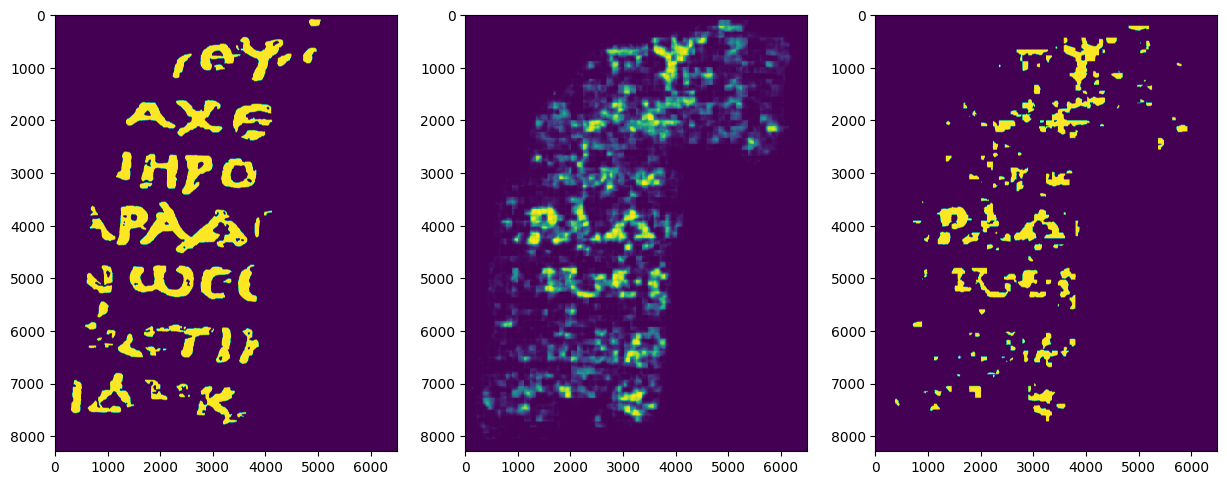

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([40200880.,  3558826.,  1960522.,  1321075.,  1011778.,   753629.,
          647745.,   581977.,   501397.,   438485.,   376682.,   346685.,
          321904.,   273612.,   251308.,   239694.,   248629.,   256497.,
          276154.,   271369.]),
 array([2.63139236e-06, 4.99125445e-02, 9.98224576e-02, 1.49732371e-01,
        1.99642284e-01, 2.49552197e-01, 2.99462110e-01, 3.49372023e-01,
        3.99281936e-01, 4.49191849e-01, 4.99101762e-01, 5.49011675e-01,
        5.98921589e-01, 6.48831502e-01, 6.98741415e-01, 7.48651328e-01,
        7.98561241e-01, 8.48471154e-01, 8.98381067e-01, 9.48290980e-01,
        9.98200893e-01]),
 <BarContainer object of 20 artists>)

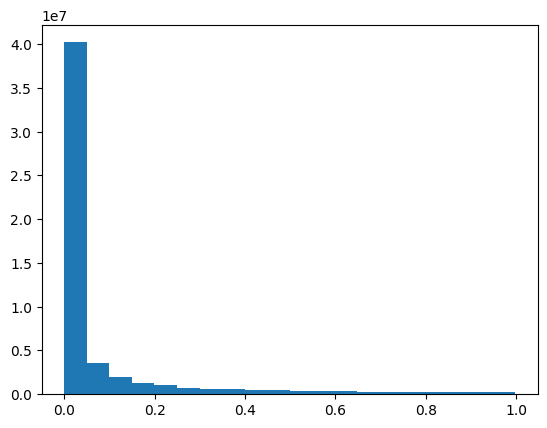

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000